# TP1 - Parte B: Classificação de Atividades Humanas 
### Tópicos de Ciência dos Dados - MECD (2022/2023)

### Autores

- Duarte Meneses - 2019216949
- Patricia Costa - 2019213995


In [1]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd

## 4.5 e 4.6 da Parte A

### 4.5. ReliefF

In [2]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances


def reliefF(X, y, **kwargs):
    """
    This function implements the reliefF feature selection
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    kwargs: {dictionary}
        parameters of reliefF:
        k: {int}
            choices for the number of neighbors (default k = 5)
    Output
    ------
    score: {numpy array}, shape (n_features,)
        reliefF score for each feature
    Reference
    ---------
    Robnik-Sikonja, Marko et al. "Theoretical and empirical analysis of relieff and rrelieff." Machine Learning 2003.
    Zhao, Zheng et al. "On Similarity Preserving Feature Selection." TKDE 2013.
    """

    if "k" not in kwargs.keys():
        k = 5
    else:
        k = kwargs["k"]
    n_samples, n_features = X.shape

    # calculate pairwise distances between instances
    distance = pairwise_distances(X, metric='manhattan')

    score = np.zeros(n_features)

    # the number of sampled instances is equal to the number of total instances
    for idx in range(n_samples):
        near_hit = []
        near_miss = dict()

        self_fea = X[idx, :]
        c = np.unique(y).tolist()

        stop_dict = dict()
        for label in c:
            stop_dict[label] = 0
        del c[c.index(y[idx])]

        p_dict = dict()
        p_label_idx = float(len(y[y == y[idx]]))/float(n_samples)

        for label in c:
            p_label_c = float(len(y[y == label]))/float(n_samples)
            p_dict[label] = p_label_c/(1-p_label_idx)
            near_miss[label] = []

        distance_sort = []
        distance[idx, idx] = np.max(distance[idx, :])

        for i in range(n_samples):
            distance_sort.append([distance[idx, i], int(i), y[i]])
        distance_sort.sort(key=lambda x: x[0])

        for i in range(n_samples):
            # find k nearest hit points
            if distance_sort[i][2] == y[idx]:
                if len(near_hit) < k:
                    near_hit.append(distance_sort[i][1])
                elif len(near_hit) == k:
                    stop_dict[y[idx]] = 1
            else:
                # find k nearest miss points for each label
                if len(near_miss[distance_sort[i][2]]) < k:
                    near_miss[distance_sort[i][2]].append(distance_sort[i][1])
                else:
                    if len(near_miss[distance_sort[i][2]]) == k:
                        stop_dict[distance_sort[i][2]] = 1
            stop = True
            for (key, value) in stop_dict.items():
                    if value != 1:
                        stop = False
            if stop:
                break

        # update reliefF score
        near_hit_term = np.zeros(n_features)
        for ele in near_hit:
            near_hit_term = np.array(abs(self_fea-X[ele, :]))+np.array(near_hit_term)

        near_miss_term = dict()
        for (label, miss_list) in near_miss.items():
            near_miss_term[label] = np.zeros(n_features)
            for ele in miss_list:
                near_miss_term[label] = np.array(abs(self_fea-X[ele, :]))+np.array(near_miss_term[label])
            score += near_miss_term[label]/(k*p_dict[label])
        score -= near_hit_term/k
    return score

## Parte B


### 1.1. Data Splitting

### 1.1.1. Train-Test (TT) e Train-Validation-Test data split

In [3]:
from sklearn.model_selection import train_test_split
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

def train_test(data, target, train_size):

    x_train, x_test, y_train, y_test = train_test_split(data, target, train_size=train_size)

    trainTest = {"TRAIN": [x_train, y_train], "TEST": [x_test, y_test]}

    return trainTest

def train_validation_test(data, target, train_size, test_size):

    x_train, x_rem, y_train, y_rem = train_test_split(data, target, train_size=train_size)

    # 1 - train_size -> correponde agora ao nosso 100%(1)
    # test_size -> test_size / (1-train_size)

    test = test_size / (1-train_size)

    x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size = test)

    trainValidation = {"TRAIN": [x_train, y_train], "TEST": [x_test, y_test], "VALIDATION": [x_valid, y_valid]}
    
    return trainValidation



### 1.1.2. K-fold data split

In [4]:
from sklearn.model_selection import KFold
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

def k_fold(x, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle = True)
    kfold = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        kfold.append({"TRAIN": [x_train, y_train], "TEST": [x_test, y_test]})
    
    return kfold

In [5]:
#Testes
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])

print("--Train Test--\n")
trainTest = train_test(X, y, 0.7)
display(trainTest)

print("\n--Train Validation Test--\n")
trainValidation = train_validation_test(X, y, 0.4, 0.3)
display(trainValidation)

print("\n--K Fold--\n")
kFold = k_fold(X, y, 4)
display(kFold)

--Train Test--



{'TRAIN': [array([[3, 4],
         [1, 2]]),
  array([2, 3])],
 'TEST': [array([[1, 2],
         [3, 4]]),
  array([1, 4])]}


--Train Validation Test--



{'TRAIN': [array([[1, 2]]), array([3])],
 'TEST': [array([[3, 4],
         [3, 4]]), array([4, 2])],
 'VALIDATION': [array([[1, 2]]), array([1])]}


--K Fold--



[{'TRAIN': [array([[1, 2],
          [3, 4],
          [1, 2]]),
   array([1, 2, 3])],
  'TEST': [array([[3, 4]]), array([4])]},
 {'TRAIN': [array([[1, 2],
          [3, 4],
          [3, 4]]),
   array([1, 2, 4])],
  'TEST': [array([[1, 2]]), array([3])]},
 {'TRAIN': [array([[3, 4],
          [1, 2],
          [3, 4]]),
   array([2, 3, 4])],
  'TEST': [array([[1, 2]]), array([1])]},
 {'TRAIN': [array([[1, 2],
          [1, 2],
          [3, 4]]),
   array([1, 3, 4])],
  'TEST': [array([[3, 4]]), array([2])]}]

### 1.2. Métricas de exactidação

In [6]:
#Teste
true = [2, 0, 2, 2, 0, 1]
pred = [0, 0, 2, 2, 0, 2]

-> Explicação do parâmetro average

**'binary'**:
Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.

**'micro'**:
Calculate metrics globally by counting the total true positives, false negatives and false positives.

**'macro'**:
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

**'weighted'**:
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

**'samples'**:
Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

Confusion Matrix:
 [[2 0 0]
 [0 0 1]
 [1 0 2]]

Recall:  0.5555555555555555

Precision:  0.4444444444444444

F1-score:  0.48888888888888893
--------------------------------------------------


,Metrics
Recall,0.555556
Precision,0.444444
F1-score,0.488889


,0,1,2
0,2,0,0
1,0,0,1
2,1,0,2


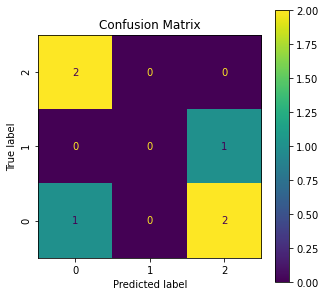

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
from sklearn.metrics import recall_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
from sklearn.metrics import precision_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
from sklearn.metrics import f1_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

def metrics(true, pred, printar = False):
    cm = confusion_matrix(true, pred)
    rs = recall_score(true, pred, average='macro', zero_division=0)
    ps = precision_score(true, pred, average='macro', zero_division=0)
    f1 = f1_score(true, pred, average='macro', zero_division=0)

    if(printar):
        print('Confusion Matrix:\n', cm)
        print('\nRecall: ', rs)
        print('\nPrecision: ', ps)
        print('\nF1-score: ', f1)
        print('-'*50)

    return [cm, rs, ps, f1]

def mais_bonito(cm, rs, ps, f1, labels):

    metricsFrame = pd.DataFrame([rs, ps, f1], columns=['Metrics']).rename(index={0: 'Recall', 1: 'Precision', 2: 'F1-score'})
    display(metricsFrame)
    
    cmFrame = pd.DataFrame(cm, columns=labels, index=labels).style.set_caption("Confusion Matrix")
    display(cmFrame)

    cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
    _, ax = plt.subplots(figsize=(5,5))
    cmp.plot(ax=ax)
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels[::-1], rotation=90)
    plt.show()
    

cm, rs, ps, f1 = metrics(true, pred, True)
mais_bonito(cm, rs, ps, f1, [0,1,2])



### 2.1. Dataset

In [18]:
iris = datasets.load_iris()

data = iris.data
target = iris.target

### 2.1. k-Nearest Neighbours

In [19]:
from sklearn.neighbors import KNeighborsClassifier

def K_neighbors_classifier(x, y, k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x, y)

    return neigh

neigh_teste = K_neighbors_classifier(data, target, 1)

### 2.1.1. Train-only

,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,50,0,0
versicolor,0,50,0
virginica,0,0,50


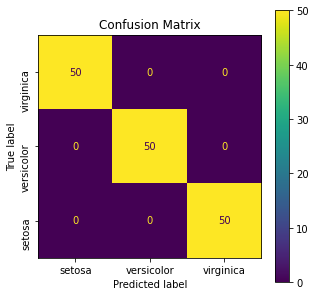

In [20]:
def TO_211(x, y, labels, k):
    neigh = K_neighbors_classifier(x, y, k)
    pred = neigh.predict(x)
    true = y
    cm, rs, ps, f1 = metrics(true, pred)
    
    mais_bonito(cm, rs, ps, f1, labels)

TO_211(data, target, iris["target_names"], 1)

### 2.1.1. TT 70-30

,Metrics
Recall,0.937951
Precision,0.927778
F1-score,0.932131


,setosa,versicolor,virginica
setosa,13,0,0
versicolor,0,19,2
virginica,0,1,10


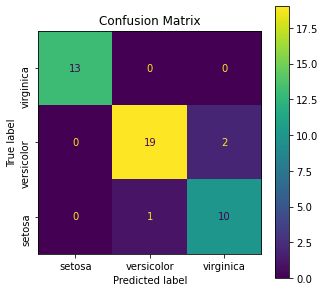

In [21]:
def TT_211(x, y, labels, k):
    trainTest = train_test(x, y, 0.7)
    neigh = K_neighbors_classifier(trainTest['TRAIN'][0], trainTest['TRAIN'][1], k)
    pred = neigh.predict(trainTest['TEST'][0])
    true = trainTest['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)
    
    mais_bonito(cm, rs, ps, f1, labels)

TT_211(data, target, iris["target_names"], 1)

### 2.1.1. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


,Metrics
Recall,0.888889
Precision,0.933333
F1-score,0.896296


,setosa,versicolor,virginica
setosa,8,0,0
versicolor,0,4,0
virginica,0,1,2


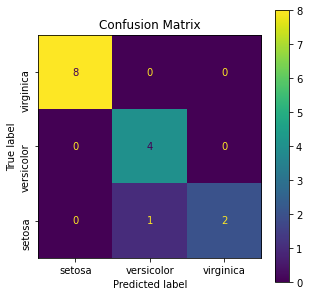

------------------- Iteração 1 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,6,0
virginica,0,0,5


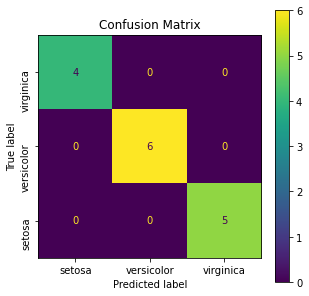

------------------- Iteração 2 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,4,0
virginica,0,0,5


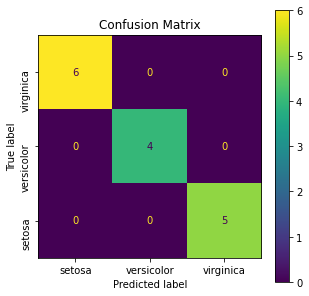

------------------- Iteração 3 -------------------


,Metrics
Recall,0.888889
Precision,0.952381
F1-score,0.907692


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,6,0
virginica,0,1,2


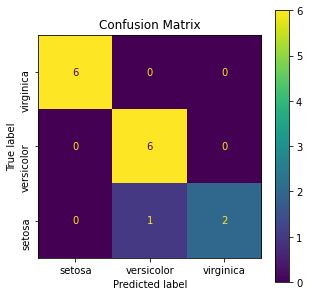

------------------- Iteração 4 -------------------


,Metrics
Recall,0.888889
Precision,0.952381
F1-score,0.907692


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,2,1
virginica,0,0,6


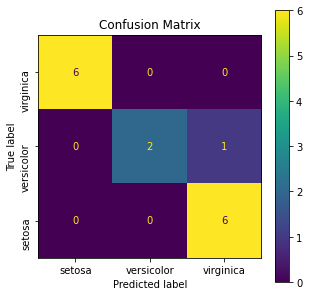

------------------- Iteração 5 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,5,0
virginica,0,0,6


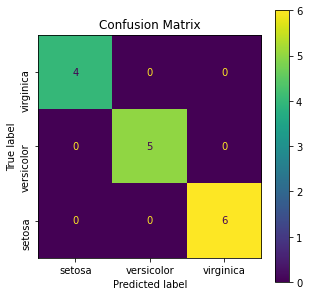

------------------- Iteração 6 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,1,0,0
versicolor,0,6,0
virginica,0,0,8


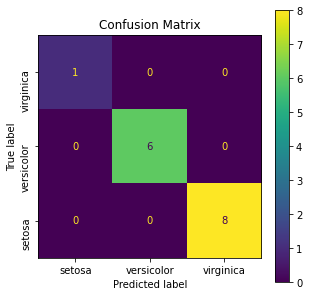

------------------- Iteração 7 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,3,0,0
versicolor,0,6,0
virginica,0,0,6


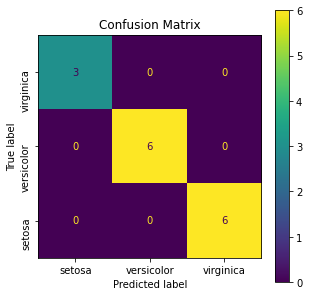

------------------- Iteração 8 -------------------


,Metrics
Recall,0.833333
Precision,0.888889
F1-score,0.822222


,setosa,versicolor,virginica
setosa,7,0,0
versicolor,0,2,2
virginica,0,0,4


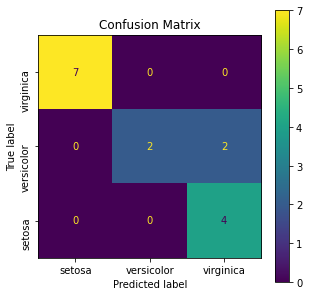

------------------- Iteração 9 -------------------


,Metrics
Recall,0.916667
Precision,0.952381
F1-score,0.926740


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,6,0
virginica,0,1,3


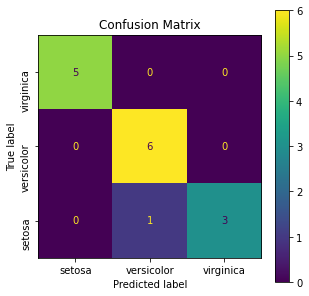

In [22]:
def CV_211(x, y, n_splits, labels, k):
    kf = k_fold(x, y, n_splits)

    count = 0
    for info in kf:
        print("------------------- Iteração " + str(count) + " -------------------")

        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        mais_bonito(cm, rs, ps, f1, labels)

        count += 1

CV_211(data, target, 10, iris["target_names"], 1)

### 2.1.2. k na gama {1, 3, 5, ...,15}

In [23]:
_k = np.arange(1, 16, 2)

display(_k)

array([ 1,  3,  5,  7,  9, 11, 13, 15])

### 2.1.2. Train-only

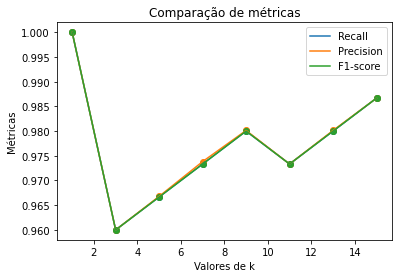

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,50,0,0
versicolor,0,50,0
virginica,0,0,50


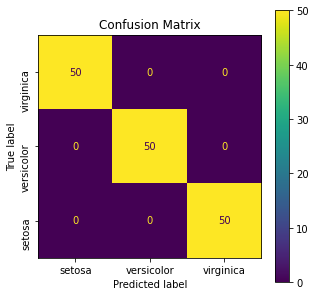

In [24]:
def TO_212(x, y, metr):
    for k in _k:
        neigh = K_neighbors_classifier(x, y, k)
        pred = neigh.predict(x)
        true = y
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)
    
    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def TO_gama(x, y):
    metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
    
    new_metr = TO_212(x, y, metr)

    plot_metricas(new_metr)

    pos_k = new_metr["Recall"].index(max(new_metr["Recall"]))
    best_k = _k[pos_k]
    print("Best K: " + str(best_k))

    neigh = K_neighbors_classifier(x, y, best_k)
    pred = neigh.predict(x)
    true = y
    cm, rs, ps, f1 = metrics(true, pred)

    mais_bonito(cm, rs, ps, f1, iris["target_names"])

TO_gama(data, target)

### 2.1.2. TVT 40-30-30

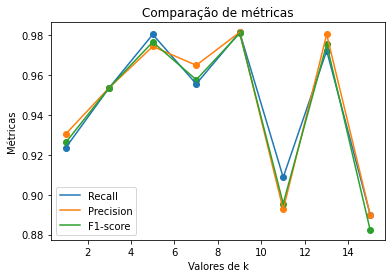

Best K: 9


,Metrics
Recall,0.962963
Precision,0.948718
F1-score,0.952614


,setosa,versicolor,virginica
setosa,16,0,0
versicolor,0,16,2
virginica,0,0,11


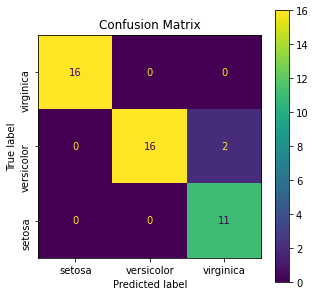

In [49]:
# TODO
# VER O MELHOR K -> FEITO
# PARA O MELHOR K, TESTAR COM O TREINO + VALIDATION JUNTOS, USANDO O TEST COMO PRED


def TVT_212(x, y, metr):
    for k in _k:
        trainValidation = train_validation_test(x, y, 0.4, 0.3)

        neigh = K_neighbors_classifier(trainValidation['TRAIN'][0], trainValidation['TRAIN'][1], k)
        pred = neigh.predict(trainValidation['VALIDATION'][0])
        true = trainValidation['VALIDATION'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)
    
    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def TVT_gama(x, y):
    metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
    
    new_metr = TVT_212(x, y, metr)

    plot_metricas(new_metr)

    pos_k = new_metr["Recall"].index(max(new_metr["Recall"]))
    best_k = _k[pos_k]
    print("Best K: " + str(best_k))

    trainValidation = train_validation_test(x, y, 0.4, 0.3)

    newTrain0 = np.concatenate((trainValidation['TRAIN'][0], trainValidation['VALIDATION'][0]), axis=0)
    newTrain1 = np.concatenate((trainValidation['TRAIN'][1], trainValidation['VALIDATION'][1]), axis=0)

    neigh = K_neighbors_classifier(newTrain0, newTrain1, best_k)
    pred = neigh.predict(trainValidation['TEST'][0])
    true = trainValidation['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)

    mais_bonito(cm, rs, ps, f1, iris["target_names"])

TVT_gama(data, target)

### 2.1.2. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


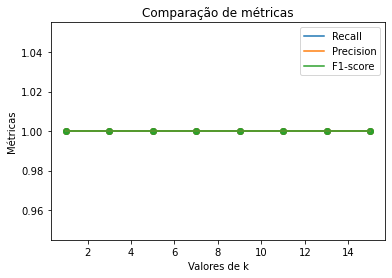

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,3,0,0
versicolor,0,6,0
virginica,0,0,6


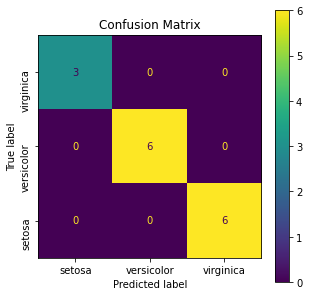

------------------- Iteração 1 -------------------


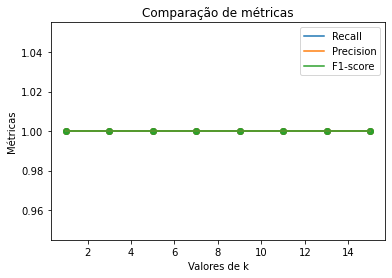

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,5,0
virginica,0,0,6


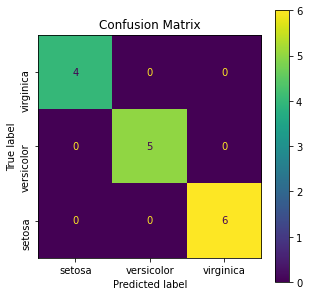

------------------- Iteração 2 -------------------


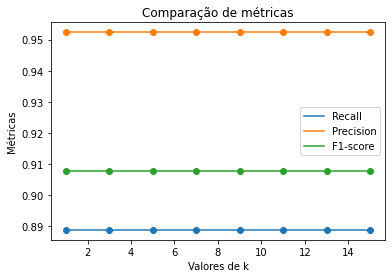

Best K: 1


,Metrics
Recall,0.888889
Precision,0.952381
F1-score,0.907692


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,2,1
virginica,0,0,6


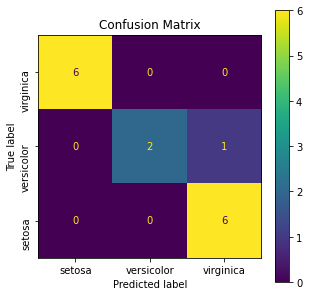

------------------- Iteração 3 -------------------


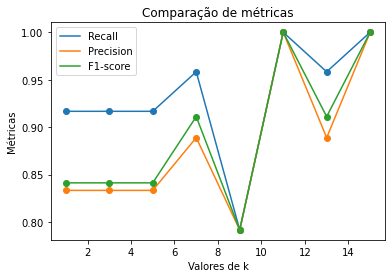

Best K: 11


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,8,0
virginica,0,0,2


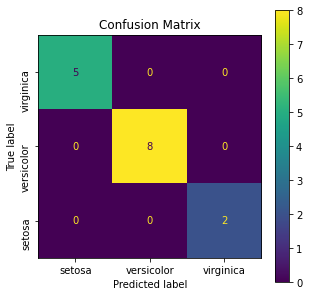

------------------- Iteração 4 -------------------


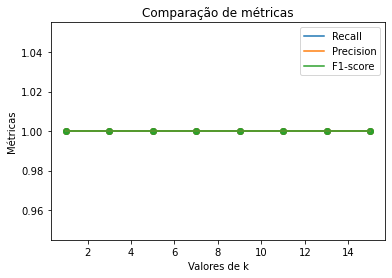

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,7,0
virginica,0,0,3


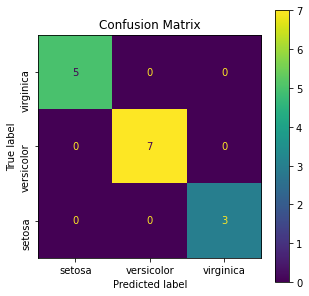

------------------- Iteração 5 -------------------


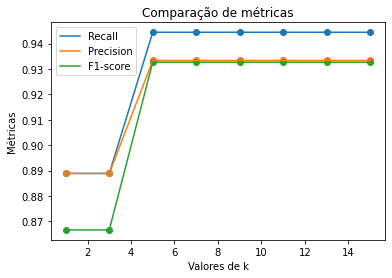

Best K: 5


,Metrics
Recall,0.944444
Precision,0.933333
F1-score,0.932660


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,4,0
virginica,0,1,5


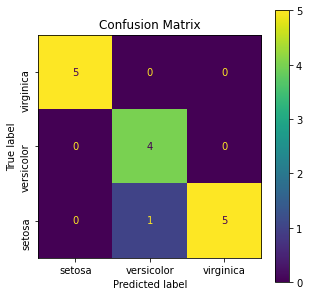

------------------- Iteração 6 -------------------


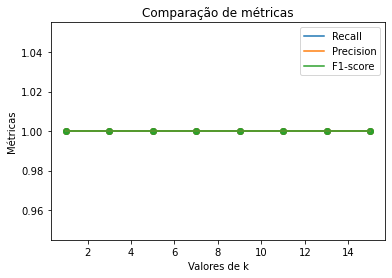

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,3,0,0
versicolor,0,5,0
virginica,0,0,7


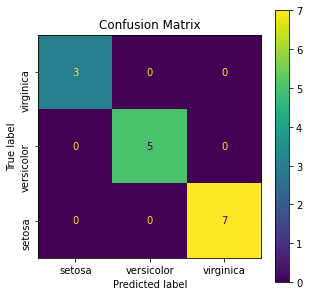

------------------- Iteração 7 -------------------


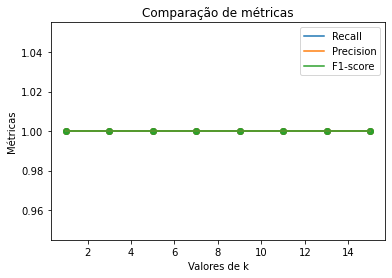

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,8,0,0
versicolor,0,3,0
virginica,0,0,4


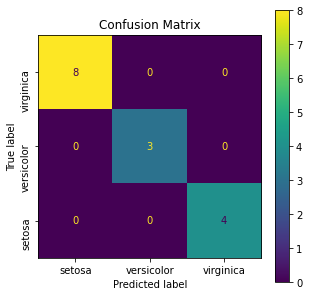

------------------- Iteração 8 -------------------


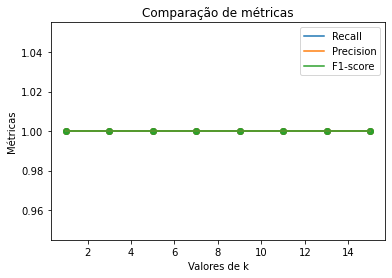

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,5,0
virginica,0,0,5


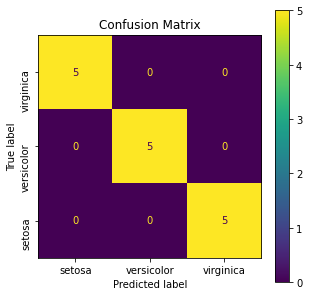

------------------- Iteração 9 -------------------


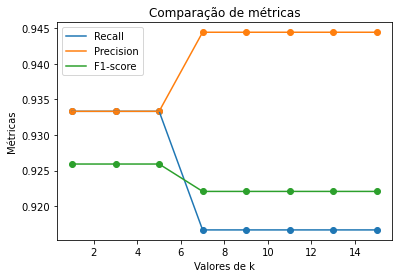

Best K: 1


,Metrics
Recall,0.933333
Precision,0.933333
F1-score,0.925926


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,4,0
virginica,0,1,4


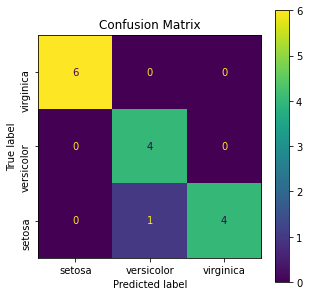

In [50]:
def CV_212(info, metr):
    for k in _k:
        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)

    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def CV_gama(x, y):
    
    kf = k_fold(x, y, 10)
    count = 0
    for info in kf:
        metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
        print("------------------- Iteração " + str(count) + " -------------------")
        count += 1
        new_metr = CV_212(info, metr)

        plot_metricas(new_metr)

        pos_k = new_metr["Recall"].index(max(new_metr["Recall"]))
        best_k = _k[pos_k]
        print("Best K: " + str(best_k))

        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], best_k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        mais_bonito(cm, rs, ps, f1, iris["target_names"])

CV_gama(data, target)